In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import torch
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import timm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from timm.models.layers.adaptive_avgmax_pool import SelectAdaptivePool2d
from torch.nn import Flatten

from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *

#import pydicom
#!pip install -qU python-gdcm pydicom pylibjpeg

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import cv2
import numpy as np

img_file = '/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/1459541791.png'
img = cv2.imread(img_file, cv2.IMREAD_COLOR)           # rgb
alpha_img = cv2.imread(img_file, cv2.IMREAD_UNCHANGED) # rgba
gray_img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)  # grayscale

print(type(img))
print('RGB shape: ', img.shape)        # Rows, cols, channels
print('ARGB shape:', alpha_img.shape)
print('Gray shape:', gray_img.shape)
print('img.dtype: ', img.dtype)
print('img.size: ', img.size)

<class 'numpy.ndarray'>
RGB shape:  (512, 512, 3)
ARGB shape: (512, 512)
Gray shape: (512, 512)
img.dtype:  uint8
img.size:  786432


In [3]:
# import cv2
# import numpy as np

# img_file = '/kaggle/working/png_file_dic/10008_1591370361.png'
# img = cv2.imread(img_file, cv2.IMREAD_COLOR)           # rgb
# alpha_img = cv2.imread(img_file, cv2.IMREAD_UNCHANGED) # rgba
# gray_img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)  # grayscale

# print(type(img))
# print('RGB shape: ', img.shape)        # Rows, cols, channels
# print('ARGB shape:', alpha_img.shape)
# print('Gray shape:', gray_img.shape)
# print('img.dtype: ', img.dtype)
# print('img.size: ', img.size)

In [4]:
df = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [5]:
df['filepath'] = '/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/' + df['patient_id'].astype(str) + '/' + df['image_id'].astype(str) + '.png'
df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,filepath
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/462822612.png
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/1459541791.png
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/1864590858.png
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/1874946579.png
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10011/220375232.png


In [6]:
df = df[['filepath', 'cancer']]
df.head()

,filepath,cancer
0,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/462822612.png,0
1,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/1459541791.png,0
2,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/1864590858.png,0
3,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/1874946579.png,0
4,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10011/220375232.png,0


In [7]:
#learn_inf = load_learner('/kaggle/input/us512-enet-ft/export.pkl')

In [8]:
db = DataBlock(blocks=(ImageBlock(), CategoryBlock),
                   get_x=lambda x:x[0],
                   get_y=lambda x:x[1],
                   splitter  = RandomSplitter(seed=1))

dls = db.dataloaders(df.values, num_workers=0, bs=32)

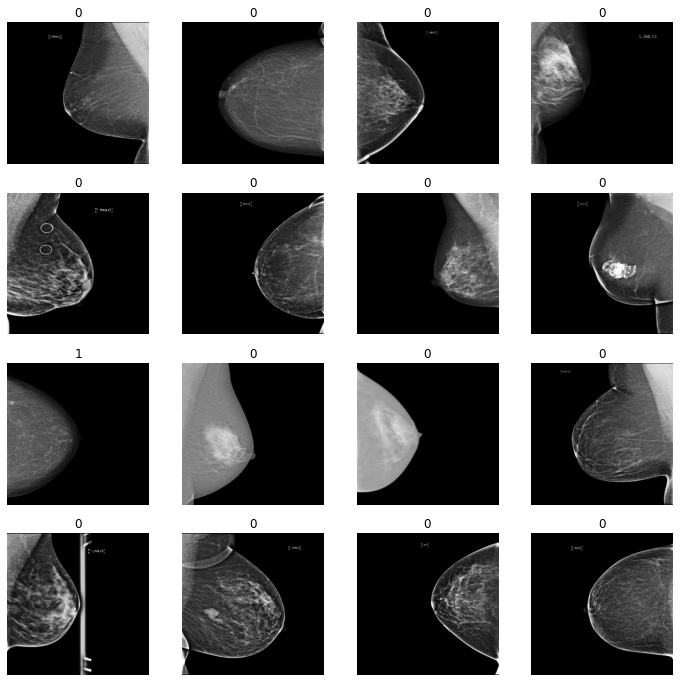

In [9]:
dls.show_batch(max_n=16)

In [10]:
def get_learner(arch=resnet18):
    learner = vision_learner(
        dls,
        arch,
        custom_head=nn.Sequential(SelectAdaptivePool2d(pool_type='avg', flatten=Flatten()), nn.Linear(1280, 2)),
        metrics=[
            error_rate,
            accuracy,
            F1Score()
        ],
        #loss_func=CrossEntropyLossFlat(weight=torch.tensor([1,20]).float()),
        loss_func=FocalLossFlat(gamma=2),
        pretrained=False,
        #normalize=False
    ).to_fp16()
    return learner

In [11]:
learn = get_learner('tf_efficientnetv2_s')

In [12]:
#learn = get_learner('tf_efficientnetv2_s')

In [13]:
learn.load('/kaggle/input/flw50-512-ch-enetv2s-ft/flw50_512_ch_enetv2_s_ft')

/opt/conda/lib/python3.7/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


# Submission|

In [14]:
temp = learn.predict('/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_dicomsdl_512/train_images_processed_cv2_dicomsdl_512/10006/1459541791.png')
temp[0]

'0'

In [15]:
test_csv = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/test.csv')
test_csv.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [16]:
image_dir_dicomsdl = '/kaggle/working/png_file_dic/'

os.makedirs(image_dir_dicomsdl, exist_ok=True)

#IMAGES_TO_PROCESS = 500

In [17]:
test_images = glob.glob("/kaggle/input/rsna-breast-cancer-detection/test_images/*/*.dcm")
len(test_images)

4

In [18]:
test_images[0]

'/kaggle/input/rsna-breast-cancer-detection/test_images/10008/736471439.dcm'

In [19]:
def process(f, size=512, save_folder=None, extension="png"):
    
    patient = f.split('/')[-2]
    image_name = f.split('/')[-1][:-4]
    
    dicom = dicoml.open(f)
    img = dicom.pixelData()

    img = (img - img.min()) / (img.max() - img.min())

    if dicom.getPixelDataInfo()['PhotometricInterpretation'] == "MONOCHROME1":
        img = 1 - img

    image = (img * 255).astype(np.uint8)
    
    img = cv2.resize(image, (size, size))

    file_name = f'{save_folder}' + f"{patient}_{image_name}.{extension}"

    cv2.imwrite(file_name, img)

In [20]:
!pip install /kaggle/input/dicomsdl-offline-installer/dicomsdl-0.109.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl

Processing /kaggle/input/dicomsdl-offline-installer/dicomsdl-0.109.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl


In [21]:
import dicomsdl as dicoml
import cv2
import pydicom

from joblib import Parallel, delayed
import glob
import time
import numpy as np
import os
from matplotlib import pyplot as plt
from tqdm import tqdm

In [22]:
Parallel(n_jobs=4)(
    delayed(process)(f, size = 512, save_folder = image_dir_dicomsdl)
    for f in test_images
)

[None, None, None, None]

In [23]:
prediction_ids = []
preds = []

for _, row in test_csv.iterrows():
    prediction_ids.append(row.prediction_id)
    pred_image_path = image_dir_dicomsdl + str(row.patient_id) + '_' + str(row.image_id) + '.png'
    pred = learn.predict(pred_image_path)[0]
    preds.append(pred)

submission = pd.DataFrame(data={'prediction_id': prediction_ids, 'cancer': preds}).groupby('prediction_id').max().reset_index()
submission.head()

,prediction_id,cancer
0,10008_L,0
1,10008_R,0


In [24]:
!rm -r png_file_dic

In [25]:
!rm -r models

In [26]:
submission.to_csv('submission.csv', index=False)